## Trigger Word Detection



## Packages


In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # This line mounts your Google Drive to the Colab notebook.

Folder_Name = 'Colab_Notebooks/DL_Project/'
# Make sure you have set the 'Folder_Name' correctly.
assert Folder_Name is not None, "[!] Enter the foldername."

import sys
# Adding the folder path to the sys.path makes Python modules in that folder available for import.
sys.path.append('/content/drive/MyDrive/{}'.format(Folder_Name))

import os
# Changing the current working directory to the folder on Google Drive.
os.chdir('/content/drive/MyDrive/{}'.format(Folder_Name))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pydub

In [ ]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
import matplotlib.pyplot as plt
from scipy.io import wavfile
%matplotlib inline

np.random.seed(1773)

## Functions related to editing the audio file

In [ ]:
# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

In [ ]:
# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

In [ ]:
# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

### Listening to Data

#### Positive

In [ ]:
IPython.display.Audio("./audio_data/help_me/yt1.WAV")

#### Negative

In [ ]:
IPython.display.Audio("./audio_data/negatives/negative_4.wav")

#### Background

In [ ]:
IPython.display.Audio("./audio_data/backgrounds/ambulance.wav")

Output hidden; open in https://colab.research.google.com to view.

### Audio Recordings to Spectrograms


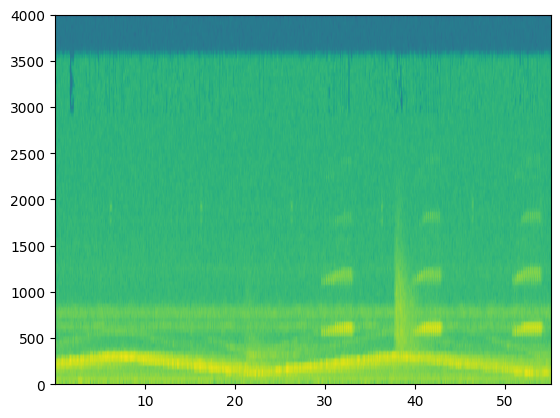

In [ ]:
x = graph_spectrogram("./audio_data/backgrounds/ambulance.wav")

* We will use audio sampled at 44100 Hz (or 44100 Hertz).
    * The microphone gives us 44,100 numbers per second.  

In [ ]:
_, data = wavfile.read("./audio_data/backgrounds/ambulance.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


In [ ]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

#### Dividing into time-intervals

In [ ]:
Ty = 1375 # The number of time steps in the output of our model

### Load Audio from File

In [ ]:
# Load raw audio files for speech synthesis
def load_raw_audio(path):
    all_help_me = []
    backgrounds = []
    negatives = []
    for filename in os.listdir(path + "help_me"):
        if filename.endswith("WAV"):
            help_me = AudioSegment.from_wav(path + "help_me/" + filename)
            all_help_me.append(help_me)
    for filename in os.listdir(path + "backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav(path + "backgrounds/" + filename)
            backgrounds.append(background)
    for filename in os.listdir(path + "negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav(path + "negatives/" + filename)
            negatives.append(negative)
    return all_help_me, negatives, backgrounds

In [ ]:
# Load audio segments using pydub
help_me, negatives, backgrounds = load_raw_audio('./audio_data/')

print("background(should be 10,000, since it is a 10 sec clip) len : " + str(len(backgrounds[0])),"\n")
print("help_me[0] len: " + str(len(help_me[0])),"\n")
print("help_me[1] len: " + str(len(help_me[1])),"\n")

background(should be 10,000, since it is a 10 sec clip) len : 10000 

help_me[0] len: 743 

help_me[1] len: 1277 



### Get a random time segment


*   Retrieves a random time segment from the background audio.



In [ ]:
def get_random_time_segment(segment_ms):

    segment_start = np.random.randint(low=0, high=10001-segment_ms)   # Segment doesn't run past the 10sec background

    segment_end = segment_start + segment_ms - 1

    return (segment_start, segment_end)

### Is Overlapping

*   Checks if a time segment overlaps with existing segments




In [ ]:
def is_overlapping(segment_time, previous_segments):

    segment_start, segment_end = segment_time

    overlap = False

    # Compare start/end times and set the flag to True if there is an overlap
    for previous_start, previous_end in previous_segments:

        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
            break

    return overlap

#### Insert_audio_clip

*   Inserts an audio segment at a random time in the background audio
*   Uses the functions get_random_time_segment and is_overlapping




In [ ]:
def insert_audio_clip(background, audio_clip, previous_segments):

    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)

    # Pick a random time segment onto which to insert the new audio clip.
    segment_time = get_random_time_segment(segment_ms)

    # Check if the new segment_time overlaps with one of the previous_segments.
    # If so, keep picking new segment_time at random until it doesn't overlap.
    retry = 10
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1

    # if last try is not overlaping, insert it to the background
    if not is_overlapping(segment_time, previous_segments):
        # Append the new segment_time to the list of previous_segments
        previous_segments.append(segment_time)
        # Superpose audio segment and background
        new_background = background.overlay(audio_clip, position = segment_time[0])
    else:
        print("Timeouted")
        new_background = background
        segment_time = (10000, 10000)

    return new_background, segment_time

In [ ]:
audio_clip, segment_time = insert_audio_clip(backgrounds[0], help_me[1], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Output hidden; open in https://colab.research.google.com to view.

#### Insert_ones


*   Inserts additional 1's into the label vector y after the word "help me"


In [ ]:
def insert_ones(y, segment_end_ms):

    _, Ty = y.shape

    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)

    if segment_end_y < Ty:
        # Add 1 to the correct index in the background label (y)
        for i in range(segment_end_y + 1, segment_end_y + 51):
            if i < Ty:
                y[0, i] = 1

    return y

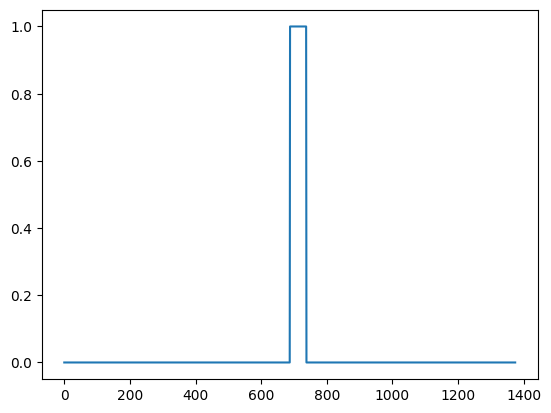

In [ ]:
# (5000 * 1375) / 10000 = 687.5
arr1 = insert_ones(np.zeros((1, Ty)), 5000)
plt.plot(arr1[0,:])

## Create a training example


1. **Background Adjustment**: Reduces the volume of the background audio.

2. **Label Initialization**: Creates an initial label vector filled with zeros.

3. **Positive Clip Insertion**: Randomly selects and inserts 0-2 "positive" audio clips (like "help me") into the background. Updates the label vector at the end of each clip.

4. **Negative Clip Insertion**: Randomly selects and inserts 0-2 "negative" audio clips (non-target sounds) into the background.

5. **Audio Normalization**: Standardizes the volume of the combined audio.

6. **Audio Export**: Saves the mixed audio as a WAV file.

7. **Spectrogram Creation**: Generates a spectrogram of the mixed audio for model input.

8. **Return Values**: Returns the spectrogram, label vector, and filename of the audio file.



In [ ]:
def create_training_example(background, positive, negatives, Ty):

    # Make background quieter
    background = background - 20

    # Initialize y (label vector) of zeros
    y = np.zeros((1,Ty))

    # Initialize segment times as empty list
    previous_segments = []

    # Select 0-2 random "help me" audio clips from the entire list of "help me" recordings
    number_of_help_me = np.random.randint(0, 3)
    random_indices = np.random.randint(len(positive), size=number_of_help_me)
    random_help_me = [positive[i] for i in random_indices]

    # Loop over randomly selected "help me" clips and insert in background
    for random_help_me in random_help_me:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_help_me, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y" at segment_end
        y = insert_ones(y, segment_end)

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background
        background, _ = insert_audio_clip(background, random_negative, previous_segments)

    # Standardize the volume of the audio clip
    background = match_target_amplitude(background, -20.0)

    # If you want export new training example
    file_name = str(number_of_help_me) + "_help_me_" + str(number_of_negatives) + "_negative_" + ".wav"
    file_handle = background.export(file_name, format="wav")

    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram(file_name)

    return x, y, file_name

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


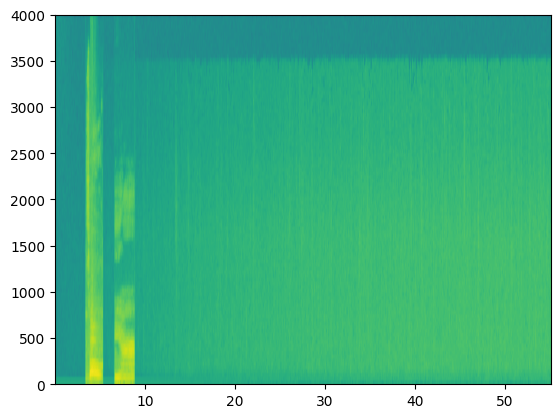

In [ ]:
# Set the random seed
x, y, name = create_training_example(backgrounds[0], help_me, negatives, Ty)

In [ ]:
print("File Name : ", name)
IPython.display.Audio(name)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.unique(y)

array([0.])

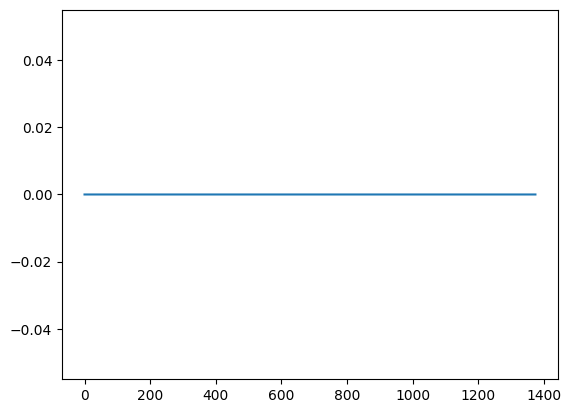

In [ ]:
plt.plot(y[0,:])

## Create Training Set

* Generate a large training set.

0
25
50
75
100
125


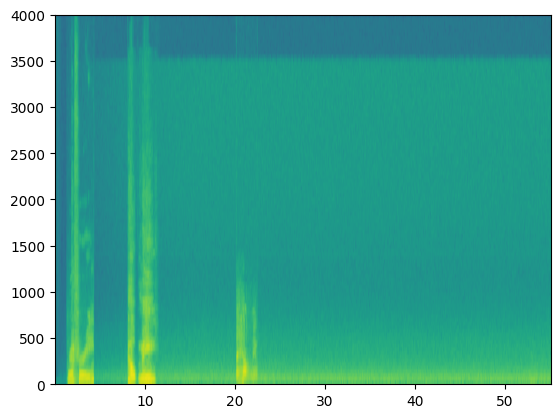

In [ ]:
nsamples = 150
X = []
Y = []
for i in range(0, nsamples):
    if i%25 == 0:
        print(i)
    x, y, name = create_training_example(backgrounds[i % 4], help_me, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)

In [70]:
print("X Shape(number_of_samples, T_x, n_freq) : ",X.shape)

X Shape(number_of_samples, T_x, n_freq) :  (150, 5511, 101)


In [71]:
print("Y Shape(number_of_samples, T_y, 1) : ",Y.shape)

Y Shape(number_of_samples, T_y, 1) :  (150, 1375, 1)


## Our Model

* A Convolutional layer
* Three GRU layers
* A Dense layer.

##### 1D convolutional layer
* It inputs the 5511 step spectrogram.  Each step is a vector of 101 units.
* It outputs a 1375 step output
* This output is further processed by multiple layers to get the final step output.

##### GRU, dense and sigmoid
* The three GRU layers read the sequence of inputs from left to right.
* A dense plus sigmoid layer makes a prediction for y.
* Because y is a binary value (0 or 1), we use a sigmoid output at the last layer to estimate the chance of the output being 1, corresponding to the user having just said "help me".

#### Unidirectional RNN
* This is really important for trigger word detection, since we want to be able to detect the trigger word almost immediately after it is said.
* If we used a bidirectional RNN, we would have to wait for the whole 10sec of audio to be recorded before we could tell if "help me" was said in the first second of the audio clip.  

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

In [ ]:
def modelf(input_shape):

    X_input = Input(shape = input_shape)


    X = Conv1D(filters=196,kernel_size=15,strides=4)(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Dropout(rate=0.7)(X)

    X = GRU(units=264, return_sequences =True)(X)
    X = Dropout(rate=0.7)(X)
    X = BatchNormalization()(X)

    X = GRU(units=264, return_sequences =True)(X)
    X = Dropout(rate=0.7)(X)
    X = BatchNormalization()(X)

    X = GRU(units=264, return_sequences = True)(X)
    X = Dropout(rate=0.7)(X)
    X = BatchNormalization()(X)
    X = Dropout(rate=0.7)(X)

    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)


    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
model = modelf(input_shape = (Tx, n_freq))

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5511, 101)]       0         
                                                                 
 conv1d (Conv1D)             (None, 1375, 196)         297136    
                                                                 
 batch_normalization (Batch  (None, 1375, 196)         784       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1375, 196)         0         
                                                                 
 dropout (Dropout)           (None, 1375, 196)         0         
                                                                 
 gru (GRU)                   (None, 1375, 264)         365904    
                                                             


### Fit the Model

In [ ]:
opt = Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [ ]:
X = np.load("./XY_train/X.npy")
Y = np.load("./XY_train/Y.npy")

In [ ]:
result = model.fit(X, Y, batch_size = 16, epochs=5)

Epoch 1/5
10/10 [==============================] - 129s 12s/step - loss: 1.2226 - accuracy: 0.4990
Epoch 2/5
10/10 [==============================] - 119s 12s/step - loss: 1.2185 - accuracy: 0.4999
Epoch 3/5
10/10 [==============================] - 120s 12s/step - loss: 1.2167 - accuracy: 0.5001
Epoch 4/5
10/10 [==============================] - 114s 12s/step - loss: 1.2123 - accuracy: 0.5013
Epoch 5/5
10/10 [==============================] - 113s 11s/step - loss: 1.2197 - accuracy: 0.4987


In [ ]:
acc_our_model = result.history['accuracy']
loss_our_model = result.history['loss']

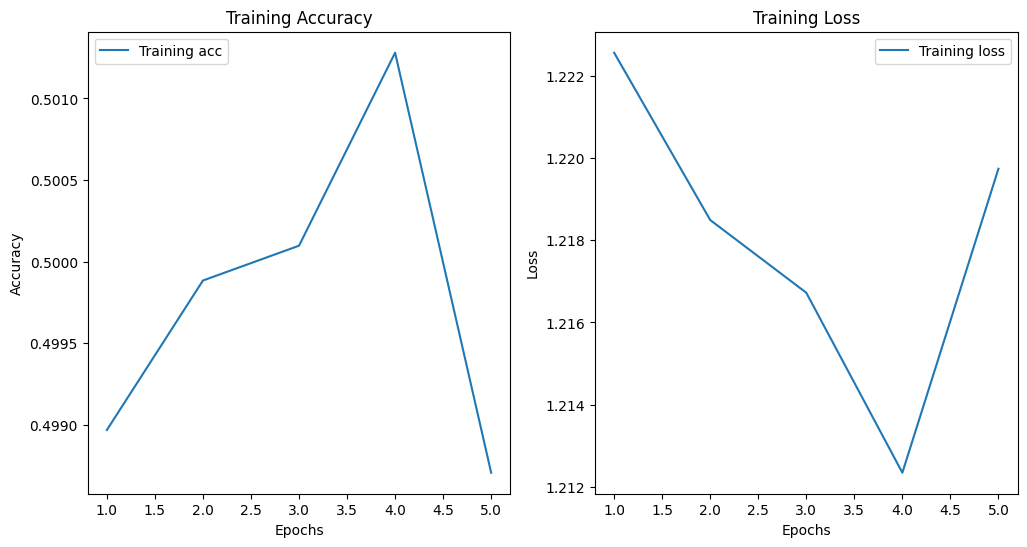

In [ ]:
epochs = range(1, len(acc_our_model) + 1)

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_our_model, label='Training acc')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_our_model, label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Our model did not produce very good results during the training process, but the results were better during the development and testing process.

#### Loading the model we trained before

In [64]:
from tensorflow.keras.models import load_model

# Load the previously saved model
model_ = load_model('./models/our_model.h5')

### Development Set

Let's see how your model performs on the development set.

In [ ]:
path = './dev_data/'

help_me_dev = []

for filename in os.listdir(path + "help_me"):
        if filename.endswith("WAV"):
            help = AudioSegment.from_wav(path + "help_me/" + filename)
            help_me_dev.append(help)

help_me_dev

0


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


10
20


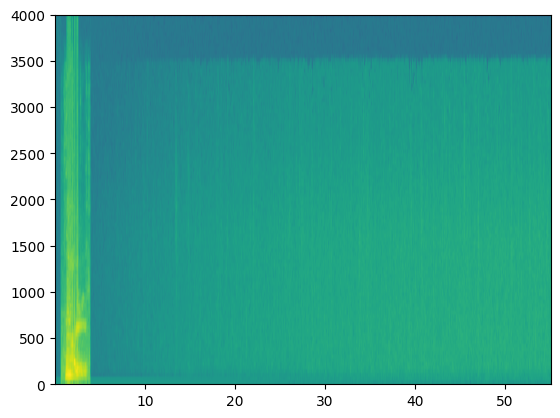

In [ ]:
nsamples = 25
X_dev = []
Y_dev = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y, name = create_training_example(backgrounds[i % 4], help_me_dev, negatives, Ty)
    X_dev.append(x.swapaxes(0,1))
    Y_dev.append(y.swapaxes(0,1))
X_dev = np.array(X_dev)
Y_dev = np.array(Y_dev)

In [ ]:
X_dev = np.load("./XY_dev/X_dev.npy")
Y_dev = np.load("./XY_dev/Y_dev.npy")

In [65]:
loss, acc_dev, = model_.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc_dev)

1/1 [==============================] - 6s 6s/step - loss: 0.6992 - accuracy: 0.7748
Dev set accuracy =  0.7747781872749329


We got a not bad development score of 0.77

### Test the Model


*   Test the model with test set.



In [ ]:
path = './test_data/'
help_me_test = []

for filename in os.listdir(path + "test"):
        if filename.endswith("WAV"):
            help = AudioSegment.from_wav(path + "test/" + filename)
            help_me_test.append(help)

help_me_test

0
10
20


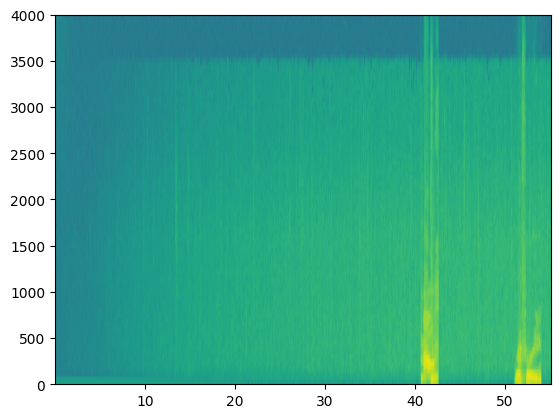

In [ ]:
nsamples = 25
X_test = []
Y_test = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y, name = create_training_example(backgrounds[i % 4], help_me_test, negatives, Ty)
    X_test.append(x.swapaxes(0,1))
    Y_test.append(y.swapaxes(0,1))
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
X_test = np.load("./XY_test/X_test.npy")
Y_test = np.load("./XY_test/Y_test.npy")

In [66]:
loss, acc_test, = model_.evaluate(X_test, Y_test)
print("Test set accuracy = ", acc_test)

1/1 [==============================] - 6s 6s/step - loss: 0.6999 - accuracy: 0.8246
Test set accuracy =  0.8245818018913269


Since the results were not good enough, we used the ready-made model that was previously trained for another word.

## Using Pretrained Model

In [ ]:
from tensorflow.keras.models import model_from_json

json_file = open('./models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('./models/model.h5')

In [ ]:
model.layers

We retrained the model with our own data by freezing some layers.

In [ ]:
model.layers[2].trainable = False
model.layers[6].trainable = False
model.layers[9].trainable = False

In [ ]:
opt = Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [ ]:
pretrained_result = model.fit(X, Y, batch_size = 16, epochs=3)

Epoch 1/3
10/10 [==============================] - 46s 4s/step - loss: 0.1705 - accuracy: 0.9617
Epoch 2/3
10/10 [==============================] - 32s 3s/step - loss: 0.1666 - accuracy: 0.9614
Epoch 3/3
10/10 [==============================] - 32s 3s/step - loss: 0.1644 - accuracy: 0.9617


In [ ]:
acc_pre_model = pretrained_result.history['accuracy']
loss_pre_model = pretrained_result.history['loss']

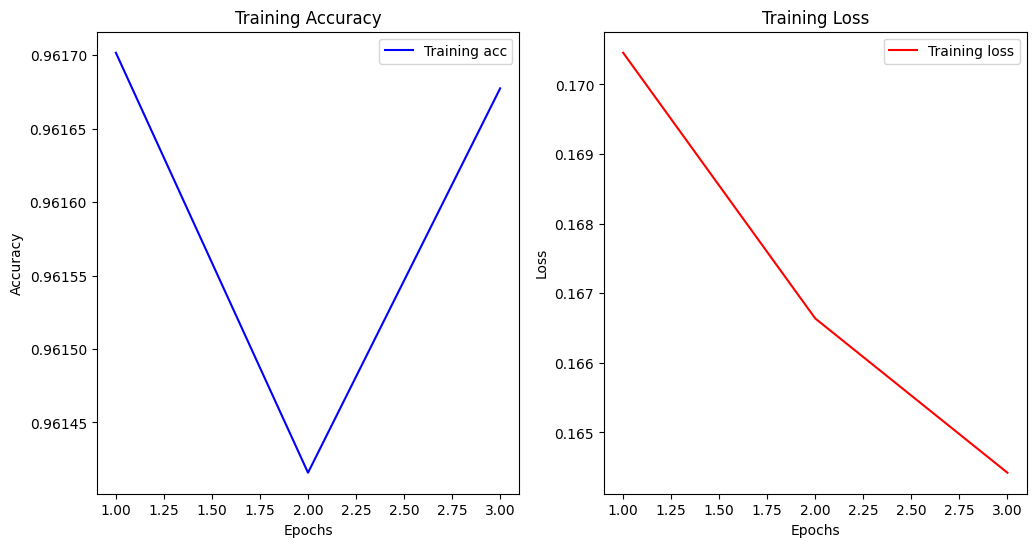

In [ ]:
epochs = range(1, len(acc_pre_model) + 1)

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_pre_model, 'b', label='Training acc')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_pre_model, 'r', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loss, acc_dev, = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc_dev)

1/1 [==============================] - 4s 4s/step - loss: 0.0904 - accuracy: 0.9683
Dev set accuracy =  0.9683200120925903


In [ ]:
loss, acc_test, = model.evaluate(X_test, Y_test)
print("Test set accuracy = ", acc_test)

1/1 [==============================] - 2s 2s/step - loss: 0.0841 - accuracy: 0.9661
Test set accuracy =  0.9661381840705872


It is clearly seen that the results are better in all processes. For this reason, we used this model in the application phase.

## Make Prediction



#### Load Pretrained Model

In [ ]:
from tensorflow.keras.models import load_model

# Load the previously saved model from the specified path
model_uploaded = load_model('./models/pre_treined_model.h5')

In [ ]:
# Evaluate the loaded model on the development set
loss, acc_dev, = model_uploaded.evaluate(X_dev, Y_dev)
# Print the accuracy on the development set
print("Dev set accuracy = ", acc_dev)

1/1 [==============================] - 2s 2s/step - loss: 0.0876 - accuracy: 0.9705
Dev set accuracy =  0.9705018401145935


In [ ]:
# Evaluate the loaded model on the test set
loss, acc_test, = model_uploaded.evaluate(X_test, Y_test)
# Print the accuracy on the test set
print("Test set accuracy = ", acc_test)

1/1 [==============================] - 1s 1s/step - loss: 0.0844 - accuracy: 0.9655
Test set accuracy =  0.9654982089996338


#### Make Prediction

In [ ]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, -20.0)

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)

    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [72]:
filename = "./prediction_samples/1_help_me_0_negative_train.wav"
prediction = detect_triggerword(filename)
IPython.display.Audio(filename)

Output hidden; open in https://colab.research.google.com to view.

In [73]:
filename = "./prediction_samples/2_help_me_1_negative_train.wav"
prediction = detect_triggerword(filename)
IPython.display.Audio(filename)

Output hidden; open in https://colab.research.google.com to view.

In [74]:
filename = "./prediction_samples/2_help_me_0_negative_.wav"
prediction = detect_triggerword(filename)
IPython.display.Audio(filename)

Output hidden; open in https://colab.research.google.com to view.

As can be seen, the model is successful in detecting trigger words. The model also detects negative words correctly.